# Import all the libraries and packages 

In [18]:
import os
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive, EmpiricalMarginal
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
from pyro.infer.inspect import get_dependencies
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
import arviz as az
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal, norm

# Get the path of all the data

In [19]:
filename_a = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp131.pkl'
filename_b = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp133.pkl'
filename_c = './Fw__Hyperspectral_datasets_from_the_KSL_cores/CuSp136.pkl'

# Load and get the data

In [20]:
with open(filename_a, 'rb') as myfile:
    a= joblib.load(myfile)
a.keys()

dict_keys(['XYZ', 'MWL_SWIRKaol', 'MWL_SWIRClay', 'BR_Fe3_Fe2_FeOH', 'BR_Anhydrite', 'BR_Gypsum', 'BR_Qtz_Fsp_Cal', 'MWL_MWIRCarbonate', 'BR_Kaol_AlOH_H2O', 'MWL_Carbonate', 'BR_Fe2_FeOH'])

# Description about Hyperspectral data
## Data is obtained by scannig the core data from different boreholes using hyperspectral sensors. There were around 450 channels for each pixels initially. It was preprocessed and seperated based on 10 different types of rocks. In each of the file we have "X", "Y", "Z" coordinates points corresponding to sensors and corresponding to each rock type we have a transformed RGB correspondence information. 

In [21]:
column_name =[]
for keys, _ in a.items():
    if keys=='XYZ':
        column_name.append("Borehole_id")
        column_name.append("X")
        column_name.append("Y")
        column_name.append("Z")
    else:
        column_name.append(keys+"_R")
        column_name.append(keys+"_G")
        column_name.append(keys+"_B")
data_a =[]
for keys, values in a.items():
    if keys=='XYZ':
        label_a = np.ones((235,1))
        data_a.append(label_a)
        data_a.append(values)
    else:
        data_a.append(values/255)

# Concatenate the arrays horizontally to create an array of size 5x30
concatenated_array_a = np.hstack(data_a)
# sort the data based on the depth
sorted_indices = np.argsort(-concatenated_array_a[:, 3])
concatenated_array_a = concatenated_array_a[sorted_indices]
concatenated_array_a.shape

(235, 34)

In [22]:
import pandas as pd
dataframe_KSL = pd.DataFrame(concatenated_array_a,columns=column_name)

In [23]:
dataframe_KSL

,Borehole_id,X,Y,Z,MWL_SWIRKaol_R,MWL_SWIRKaol_G,MWL_SWIRKaol_B,MWL_SWIRClay_R,MWL_SWIRClay_G,MWL_SWIRClay_B,...,MWL_MWIRCarbonate_B,BR_Kaol_AlOH_H2O_R,BR_Kaol_AlOH_H2O_G,BR_Kaol_AlOH_H2O_B,MWL_Carbonate_R,MWL_Carbonate_G,MWL_Carbonate_B,BR_Fe2_FeOH_R,BR_Fe2_FeOH_G,BR_Fe2_FeOH_B
0,1.0,101726.067469,1.256648e+06,-192.063946,0.000000,0.000000,0.000000,0.000000,0.000000,0.007843,...,0.007843,0.0,0.007843,0.015686,0.000000,0.000000,0.000000,0.0,0.0,0.003922
1,1.0,462396.723231,5.712055e+06,-757.994770,0.027451,0.003922,0.003922,0.019608,0.003922,0.003922,...,0.203922,0.0,0.000000,0.956863,0.058824,0.011765,0.007843,0.0,0.0,0.000000
2,1.0,462396.707804,5.712055e+06,-758.491319,0.019608,0.003922,0.003922,0.007843,0.000000,0.000000,...,0.180392,0.0,0.000000,0.917647,0.035294,0.019608,0.011765,0.0,0.0,0.000000
3,1.0,462396.691591,5.712055e+06,-758.987619,0.027451,0.003922,0.003922,0.019608,0.003922,0.003922,...,0.262745,0.0,0.000000,1.000000,0.066667,0.023529,0.015686,0.0,0.0,0.000000
4,1.0,462396.675420,5.712055e+06,-759.483931,0.015686,0.000000,0.000000,0.003922,0.000000,0.000000,...,0.188235,0.0,0.000000,0.686275,0.058824,0.039216,0.019608,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1.0,462391.365850,5.712036e+06,-870.771163,0.007843,0.000000,0.000000,0.015686,0.062745,0.082353,...,0.058824,0.0,0.082353,0.156863,0.011765,0.007843,0.011765,0.0,0.0,0.019608
231,1.0,462391.333756,5.712036e+06,-871.258504,0.015686,0.000000,0.000000,0.035294,0.121569,0.180392,...,0.133333,0.0,0.172549,0.321569,0.027451,0.019608,0.023529,0.0,0.0,0.058824
232,1.0,462391.301701,5.712036e+06,-871.745859,0.019608,0.003922,0.003922,0.027451,0.054902,0.133333,...,0.113725,0.0,0.160784,0.286275,0.027451,0.023529,0.027451,0.0,0.0,0.062745
233,1.0,462391.268635,5.712036e+06,-872.233237,0.015686,0.003922,0.003922,0.027451,0.039216,0.117647,...,0.090196,0.0,0.149020,0.278431,0.027451,0.023529,0.027451,0.0,0.0,0.058824


In [24]:
spectral_data = dataframe_KSL.iloc[:,4:]
spectral_data

,MWL_SWIRKaol_R,MWL_SWIRKaol_G,MWL_SWIRKaol_B,MWL_SWIRClay_R,MWL_SWIRClay_G,MWL_SWIRClay_B,BR_Fe3_Fe2_FeOH_R,BR_Fe3_Fe2_FeOH_G,BR_Fe3_Fe2_FeOH_B,BR_Anhydrite_R,...,MWL_MWIRCarbonate_B,BR_Kaol_AlOH_H2O_R,BR_Kaol_AlOH_H2O_G,BR_Kaol_AlOH_H2O_B,MWL_Carbonate_R,MWL_Carbonate_G,MWL_Carbonate_B,BR_Fe2_FeOH_R,BR_Fe2_FeOH_G,BR_Fe2_FeOH_B
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.007843,0.023529,0.0,0.003922,0.000000,...,0.007843,0.0,0.007843,0.015686,0.000000,0.000000,0.000000,0.0,0.0,0.003922
1,0.027451,0.003922,0.003922,0.019608,0.003922,0.003922,0.000000,0.0,0.000000,0.949020,...,0.203922,0.0,0.000000,0.956863,0.058824,0.011765,0.007843,0.0,0.0,0.000000
2,0.019608,0.003922,0.003922,0.007843,0.000000,0.000000,0.000000,0.0,0.000000,0.909804,...,0.180392,0.0,0.000000,0.917647,0.035294,0.019608,0.011765,0.0,0.0,0.000000
3,0.027451,0.003922,0.003922,0.019608,0.003922,0.003922,0.000000,0.0,0.000000,0.992157,...,0.262745,0.0,0.000000,1.000000,0.066667,0.023529,0.015686,0.0,0.0,0.000000
4,0.015686,0.000000,0.000000,0.003922,0.000000,0.000000,0.000000,0.0,0.000000,0.694118,...,0.188235,0.0,0.000000,0.686275,0.058824,0.039216,0.019608,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.007843,0.000000,0.000000,0.015686,0.062745,0.082353,0.188235,0.0,0.019608,0.000000,...,0.058824,0.0,0.082353,0.156863,0.011765,0.007843,0.011765,0.0,0.0,0.019608
231,0.015686,0.000000,0.000000,0.035294,0.121569,0.180392,0.341176,0.0,0.058824,0.000000,...,0.133333,0.0,0.172549,0.321569,0.027451,0.019608,0.023529,0.0,0.0,0.058824
232,0.019608,0.003922,0.003922,0.027451,0.054902,0.133333,0.278431,0.0,0.062745,0.000000,...,0.113725,0.0,0.160784,0.286275,0.027451,0.023529,0.027451,0.0,0.0,0.062745
233,0.015686,0.003922,0.003922,0.027451,0.039216,0.117647,0.270588,0.0,0.058824,0.000000,...,0.090196,0.0,0.149020,0.278431,0.027451,0.023529,0.027451,0.0,0.0,0.058824


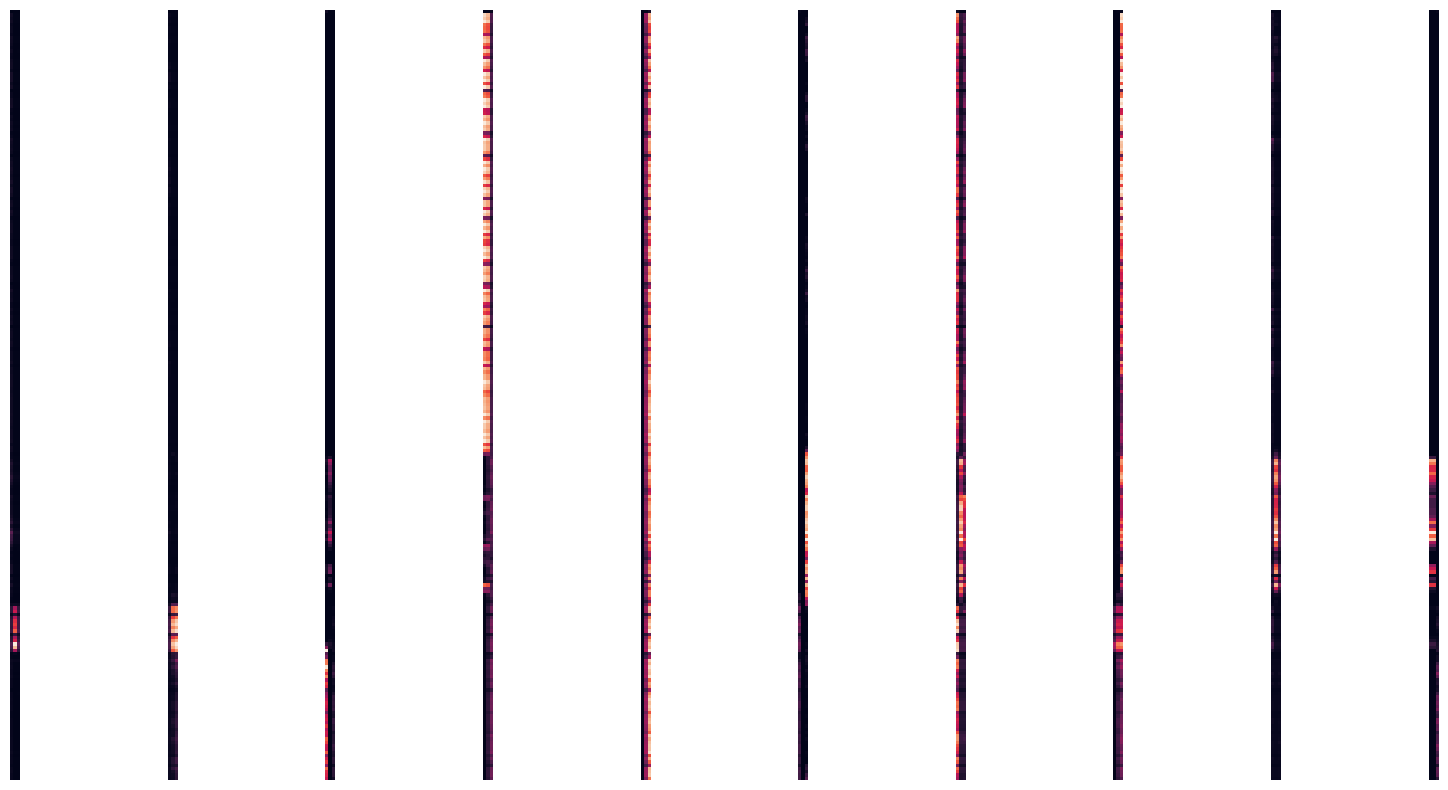

In [25]:
fig, ax = plt.subplots(1, 10, figsize=(20,10))
for i in range(10):
    colum_start = 3 *i
    colum_end = 3 *i +3
 
    ax[i].imshow(spectral_data.iloc[:,colum_start:colum_end]) 
    
# Remove axis labels for clarity
for ax in ax:
    ax.axis('off')


In [26]:
column_list =['BR_Anhydrite_R',
 'BR_Anhydrite_G',
 'BR_Anhydrite_B',
 'BR_Qtz_Fsp_Cal_R',
 'BR_Qtz_Fsp_Cal_G',
 'BR_Qtz_Fsp_Cal_B'
 ]
hsi_data = dataframe_KSL[column_list]
hsi_data

,BR_Anhydrite_R,BR_Anhydrite_G,BR_Anhydrite_B,BR_Qtz_Fsp_Cal_R,BR_Qtz_Fsp_Cal_G,BR_Qtz_Fsp_Cal_B
0,0.000000,0.007843,0.023529,0.015686,0.0,0.000000
1,0.949020,0.866667,0.203922,0.000000,0.0,0.000000
2,0.909804,0.831373,0.196078,0.000000,0.0,0.035294
3,0.992157,0.905882,0.215686,0.000000,0.0,0.062745
4,0.694118,0.631373,0.149020,0.000000,0.0,0.125490
...,...,...,...,...,...,...
230,0.000000,0.054902,0.121569,0.070588,0.0,0.094118
231,0.000000,0.117647,0.262745,0.156863,0.0,0.125490
232,0.000000,0.125490,0.282353,0.184314,0.0,0.066667
233,0.000000,0.125490,0.290196,0.168627,0.0,0.149020


# Since it is difficult to classify a hyperspectral data in general. We can apply different classical clustering methods to have some starting guess

In [28]:

#gm = KMeans(n_clusters=3, random_state=42).fit(X)
#gm = GaussianMixture(n_components=3, random_state=0).fit(X)
gm = BayesianGaussianMixture(n_components=3,covariance_type='full', random_state=0).fit(hsi_data)

In [29]:
gm.means_ , gm.covariances_

(array([[7.71968839e-01, 7.05429203e-01, 1.67939396e-01, 4.09525013e-04,
         0.00000000e+00, 2.91311307e-02],
        [9.40121984e-02, 1.71913397e-01, 2.09966969e-01, 3.27839958e-03,
         0.00000000e+00, 7.28620311e-01],
        [8.19402576e-03, 1.15901741e-01, 2.47505076e-01, 1.65117002e-01,
         0.00000000e+00, 4.19518439e-02]]),
 array([[[ 4.33002341e-02,  3.92883055e-02,  8.77528201e-03,
          -3.05456806e-04,  0.00000000e+00,  5.32015149e-05],
         [ 3.92883055e-02,  3.56846591e-02,  8.03772688e-03,
          -2.44771188e-04,  0.00000000e+00,  1.57119257e-04],
         [ 8.77528201e-03,  8.03772688e-03,  1.95029488e-03,
           1.20617224e-05,  0.00000000e+00,  2.54546847e-04],
         [-3.05456806e-04, -2.44771188e-04,  1.20617224e-05,
           5.65984466e-05,  0.00000000e+00, -3.76308121e-07],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  9.57443183e-07,  0.00000000e+00],
         [ 5.32015149e-05,  1.57119257

In [30]:
loc_mean = torch.tensor(gm.means_)
loc_cov  = torch.tensor(gm.covariances_)

In [31]:
y_gmm_label = gm.predict(hsi_data)
print(y_gmm_label)

y_gmm_label_arranged = torch.Tensor(y_gmm_label+1)
y_gmm_label_arranged 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2]


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 

# We use the normalised hsi data y_obs_label information

In [32]:

y_obs_label = hsi_data

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


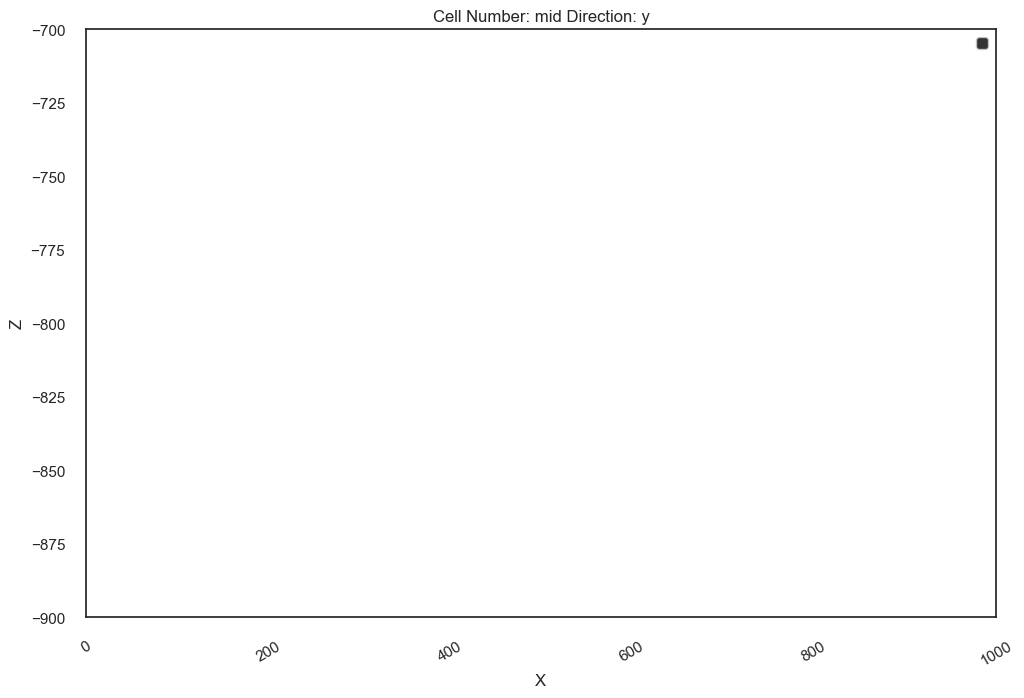

In [33]:
geo_model_test = gp.create_geomodel(
    project_name='Gempy_abc_Test',
    extent=[0, 1000, -500, 500, -900, -700],
    resolution=[100,100,100],
    refinement=3,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
p2d = gpv.plot_2d(geo_model_test)

In [34]:
geo_model_test.grid.active_grids_bool

array([False, False, False, False, False])

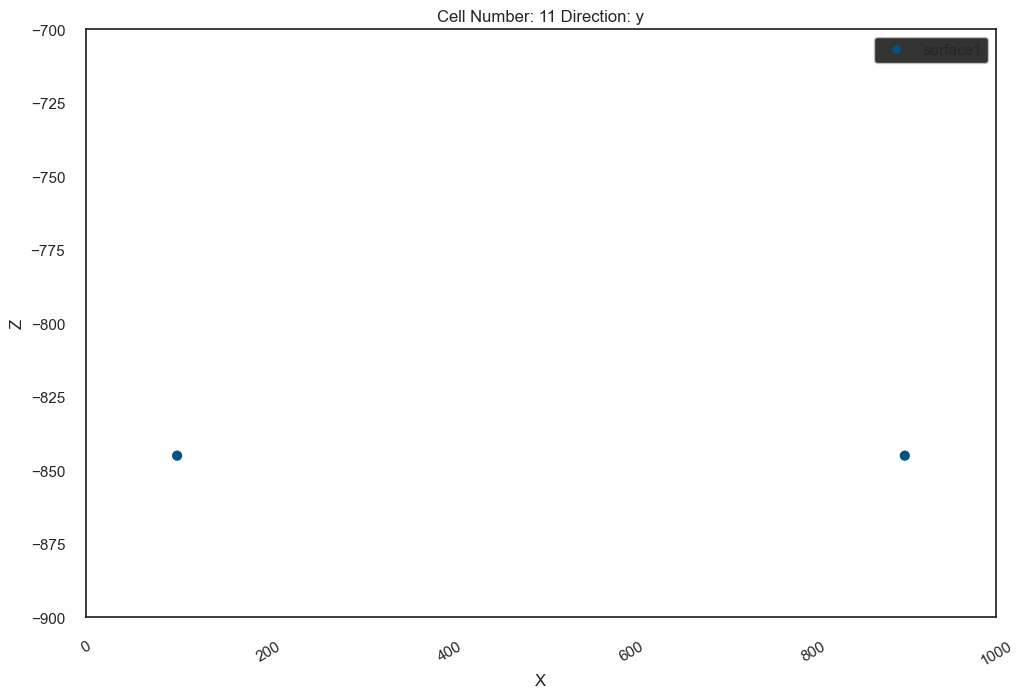

In [35]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[100.0, 900.0],
    y=[0.0, 0.0],
    z=[brk1, brk1],
    elements_names=['surface1', 'surface1']
)
gpv.plot_2d(geo_model_test, cell_number=11)

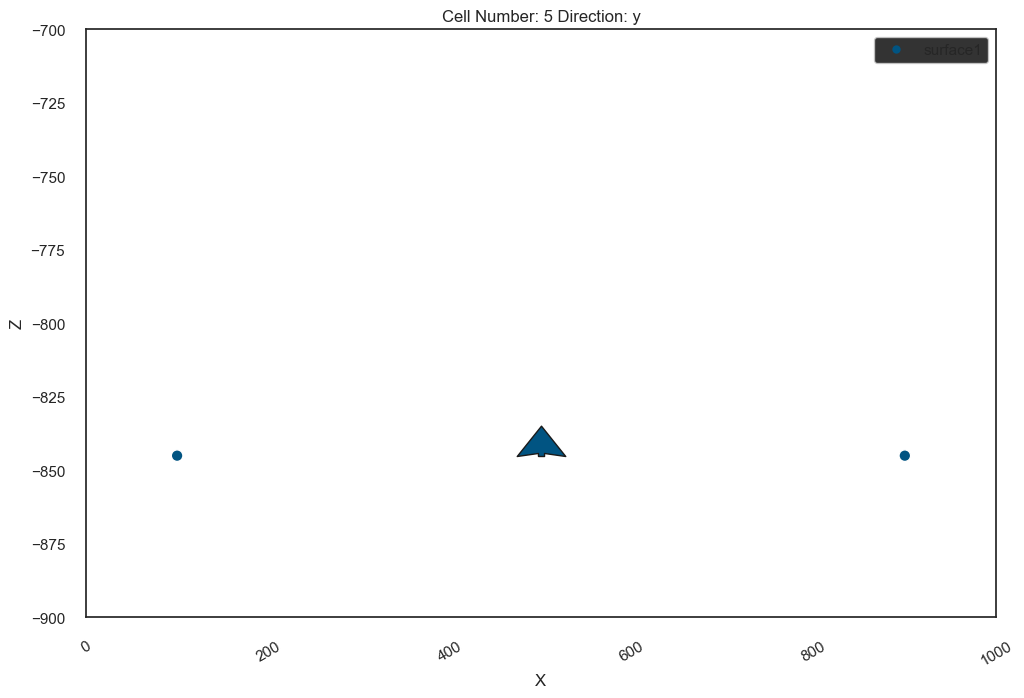

In [36]:
gp.add_orientations(
    geo_model=geo_model_test,
    x=[500],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1]]
)

gpv.plot_2d(geo_model_test, cell_number=5)

In [37]:
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)

In [38]:
gp.compute_model(geo_model_test, engine_config=gp.data.GemPyEngineConfig())

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Solutions(3 Octree Levels, 1 DualContouringMeshes)

In [39]:
geo_model_test.interpolation_options.kernel_options

KernelOptions(range=5, c_o=10, uni_degree=1, i_res=4, gi_res=2, number_dimensions=3, kernel_function=AvailableKernelFunctions.cubic, compute_condition_number=False, kernel_solver=Solvers.DEFAULT)

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


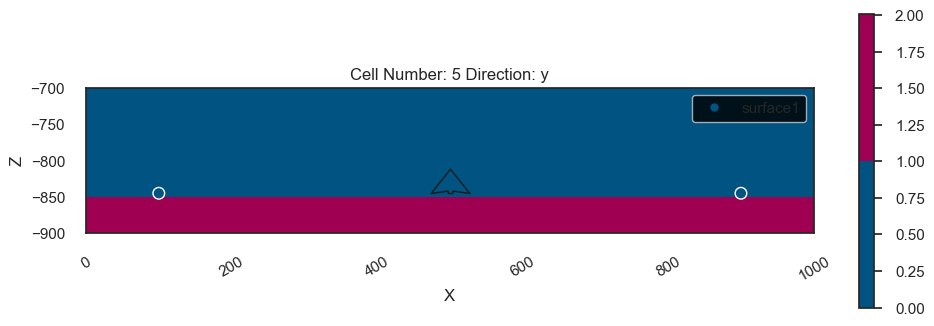

In [40]:
gpv.plot_2d(geo_model_test, cell_number=[5])

In [41]:
#gpv.plot_3d(geo_model_test, show_surfaces=True, image=True)

In [42]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [43]:
brk2

-825

Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


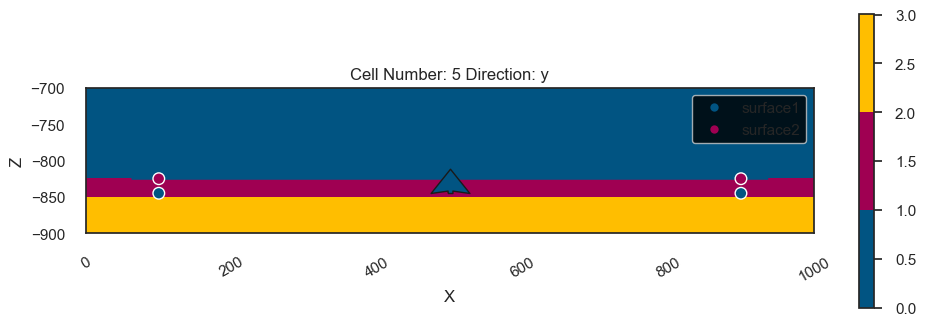

In [44]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_test.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([100.0, 900.0]),
        y=np.array([0.0, 0.0]),
        z=np.array([brk2, brk2]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

geo_model_test.structural_frame.structural_groups[0].append_element(element2)
# Compute and visualize the updated model:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')
    

In [45]:
#gpv.plot_3d(geo_model_test, image=True)

In [46]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface1,
	color=#015482,
	is_active=True
),
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [47]:
geo_model_test.structural_frame.structural_groups[0].elements[0], geo_model_test.structural_frame.structural_groups[0].elements[1] = \
geo_model_test.structural_frame.structural_groups[0].elements[1], geo_model_test.structural_frame.structural_groups[0].elements[0]

In [48]:
geo_model_test.structural_frame

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=default_formations,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=surface2,
	color=#9f0052,
	is_active=True
),
Element(
	name=surface1,
	color=#015482,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

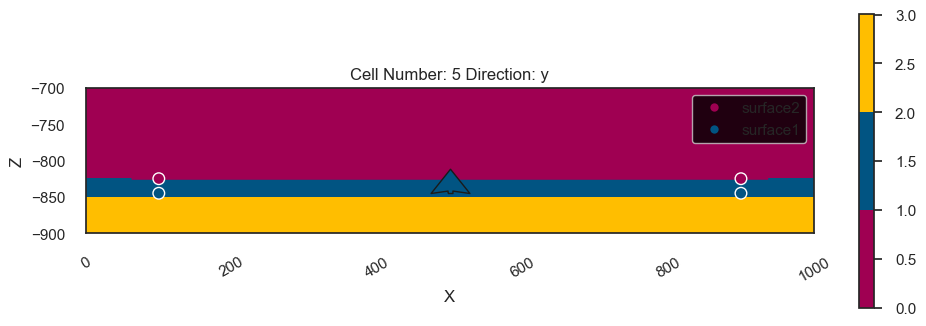

In [49]:
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

# Create a custome grid where the observed data information is available 

In [50]:
x_loc = 300
y_loc = 0
z_loc = dataframe_KSL['Z']
xyz_coord = np.array([[x_loc, y_loc, z] for z in z_loc])
gp.set_custom_grid(geo_model_test.grid, xyz_coord=xyz_coord)

Active grids: ['custom']


In [51]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.]])

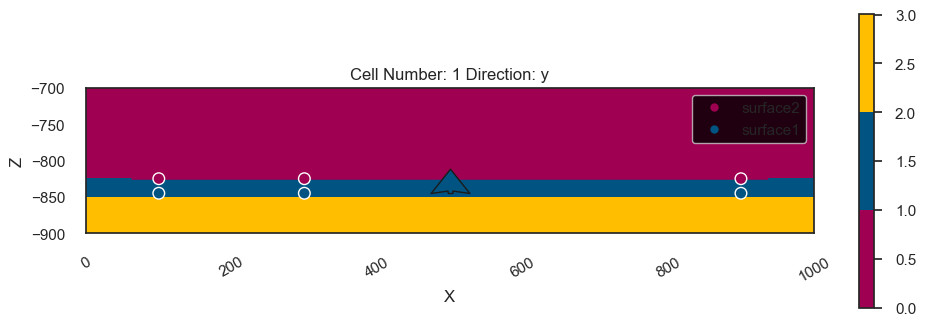

In [52]:
gp.add_surface_points(
    geo_model=geo_model_test,
    x=[x_loc, x_loc],
    y=[0.0, 0.0],
    z=[brk1, brk2],
    elements_names=['surface1', 'surface2']
)
gpv.plot_2d(geo_model_test, cell_number=1)

In [53]:
geo_model_test.surface_points

X,Y,Z,id,nugget
100.00,0.00,-825.00,79273328,0.00
900.00,0.00,-825.00,79273328,0.00
300.00,0.00,-825.00,79273328,0.00
100.00,0.00,-845.00,14488294,0.00
900.00,0.00,-845.00,14488294,0.00
300.00,0.00,-845.00,14488294,0.00


Setting Backend To: AvailableBackends.numpy


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_viewer/API/_plot_2d_API.py:172: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


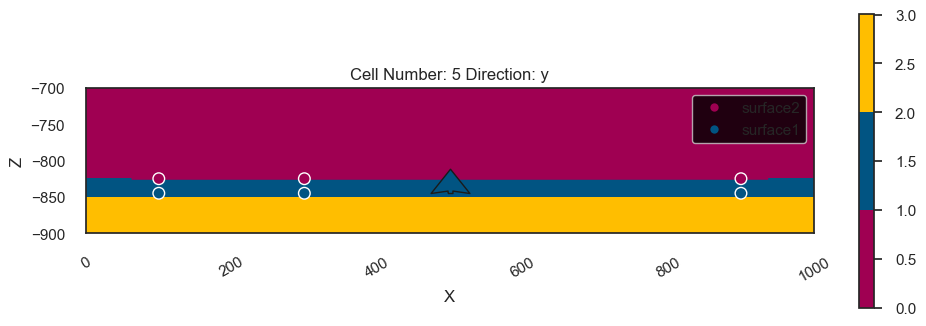

In [54]:
gp.compute_model(geo_model_test)
gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [55]:
sp_coords_copy_test = geo_model_test.interpolation_input.surface_points.sp_coords.copy()
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 300.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.],
       [ 300.,    0., -845.]])

In [56]:
# Change the backend to PyTorch for probabilistic modeling
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH)

Setting Backend To: AvailableBackends.PYTORCH


In [57]:
geo_model_test.interpolation_options.uni_degree = 0
geo_model_test.interpolation_options.mesh_extraction = False
geo_model_test.interpolation_options.sigmoid_slope = 1100.

In [58]:
#geo_model_test.solutions.octrees_output[0].last_output_center

In [59]:
custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
custom_grid_values

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [60]:
y_obs_label.shape

(235, 6)

In [61]:
geo_model_test.surface_points

X,Y,Z,id,nugget
100.00,0.00,-825.00,79273328,0.00
900.00,0.00,-825.00,79273328,0.00
300.00,0.00,-825.00,79273328,0.00
100.00,0.00,-845.00,14488294,0.00
900.00,0.00,-845.00,14488294,0.00
300.00,0.00,-845.00,14488294,0.00


In [62]:
geo_model_test.orientations

X,Y,Z,G_x,G_y,G_z,id,nugget
500.00,0.00,-845.00,0.00,0.00,1.00,14488294,0.01


In [63]:
geo_model_test.transform.apply_inverse(sp_coords_copy_test)

array([[ 100.,    0., -825.],
       [ 900.,    0., -825.],
       [ 300.,    0., -825.],
       [ 100.,    0., -845.],
       [ 900.,    0., -845.],
       [ 300.,    0., -845.]])

In [64]:
y_obs_label = torch.tensor(y_obs_label.to_numpy(),dtype=torch.float64)
y_obs_label

tensor([[0.0000, 0.0078, 0.0235, 0.0157, 0.0000, 0.0000],
        [0.9490, 0.8667, 0.2039, 0.0000, 0.0000, 0.0000],
        [0.9098, 0.8314, 0.1961, 0.0000, 0.0000, 0.0353],
        ...,
        [0.0000, 0.1255, 0.2824, 0.1843, 0.0000, 0.0667],
        [0.0000, 0.1255, 0.2902, 0.1686, 0.0000, 0.1490],
        [0.0000, 0.1098, 0.2471, 0.1725, 0.0000, 0.2118]], dtype=torch.float64)

Condition number: 30555.488813314183.
Condition number: 30555.488813314183.


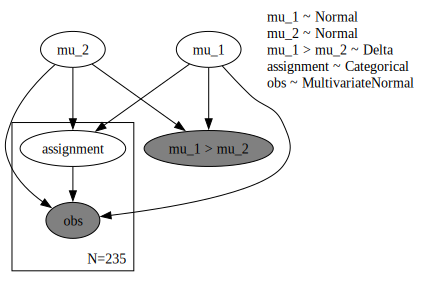

In [65]:



@config_enumerate
def model_test(y_obs_label):
    """
    This Pyro model represents the probabilistic aspects of the geological model.
    It defines a prior distribution for the top layer's location and
    computes the thickness of the geological layer as an observed variable.
    """
    # Define prior for the top layer's location
    prior_mean_surface_1 = sp_coords_copy_test[2, 2]
    prior_mean_surface_2 = sp_coords_copy_test[5, 2]
    
    

    mu_surface_1 = pyro.sample('mu_1', dist.Normal(prior_mean_surface_1, torch.tensor(0.02, dtype=torch.float64)))
    mu_surface_2 = pyro.sample('mu_2', dist.Normal(prior_mean_surface_2, torch.tensor(0.02, dtype=torch.float64)))    
    
    
    # Ensure that mu_surface_1 is greater than mu_surface_2
    pyro.sample('mu_1 > mu_2', dist.Delta(torch.tensor(1.0, dtype=torch.float64)), obs=(mu_surface_1 > mu_surface_2))
    # Update the model with the new top layer's location
    interpolation_input = geo_model_test.interpolation_input
    
    
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([2]), torch.tensor([2])),
        mu_surface_1
    )
    interpolation_input.surface_points.sp_coords = torch.index_put(
        interpolation_input.surface_points.sp_coords,
        (torch.tensor([5]), torch.tensor([2])),
        mu_surface_2
    )
    
    
    # # Compute the geological model
    geo_model_test.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model_test.interpolation_options,
        data_descriptor=geo_model_test.input_data_descriptor,
        geophysics_input=geo_model_test.geophysics_input,
    )
    
    # Compute and observe the thickness of the geological layer
    
    custom_grid_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    lambda_ = 20
    # #class_label = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    z_nk = F.softmax(-lambda_* (torch.tensor([1,2,3], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1)
    # #class_label = torch.mean(F.softmax(-lambda_* (torch.tensor([1,2,3,4,5,6], dtype=torch.float64) - custom_grid_values.reshape(-1,1))**2, dim=1),dim=0)
    
    N_k = torch.sum(z_nk,axis=0)
    N = len(custom_grid_values)
    pi_k = N_k /N
    #print(pi_k)
    mean = []
    cov = []
    for i in range(z_nk.shape[1]):
        mean_k = torch.sum( z_nk[:,i][:,None] * y_obs_label, axis=0)/ N_k[i]
        #cov_k = torch.sum( (normalised_hsi - mean_k.reshape((-1,1))) (normalised_hsi - mean_k).T )
        cov_k = torch.zeros((mean_k.shape[0],mean_k.shape[0]),dtype=torch.float64)
        for j in range(z_nk.shape[0]):
                cov_k +=  z_nk[j,i]* torch.matmul((y_obs_label[j,:] - mean_k).reshape((-1,1)) ,(y_obs_label[j,:] - mean_k).reshape((1,-1)))
        mean.append(mean_k)
        cov_k=cov_k/N_k[i] + 1e-5 * torch.diag(torch.ones(cov_k.shape[0],dtype=torch.float64))
        cov.append(cov_k)
    mean_tensor = torch.stack(mean, dim=0)
    cov_tensor = torch.stack(cov,dim=0)
    
    
    with pyro.plate('N='+str(y_obs_label.shape[0]), y_obs_label.shape[0]):
        assignment = pyro.sample("assignment", dist.Categorical(pi_k))
        
        obs = pyro.sample("obs", dist.MultivariateNormal(loc=mean_tensor[assignment],covariance_matrix=cov_tensor[assignment]), obs=y_obs_label)
        
    return obs
dependencies = get_dependencies(model_test, model_args=(y_obs_label,))
pyro.render_model(model_test, model_args=(y_obs_label,),render_distributions=True)

In [66]:
print( y_obs_label.shape)
model_test(y_obs_label)

torch.Size([235, 6])
Condition number: 30555.4888133142.


tensor([[0.0000, 0.0078, 0.0235, 0.0157, 0.0000, 0.0000],
        [0.9490, 0.8667, 0.2039, 0.0000, 0.0000, 0.0000],
        [0.9098, 0.8314, 0.1961, 0.0000, 0.0000, 0.0353],
        ...,
        [0.0000, 0.1255, 0.2824, 0.1843, 0.0000, 0.0667],
        [0.0000, 0.1255, 0.2902, 0.1686, 0.0000, 0.1490],
        [0.0000, 0.1098, 0.2471, 0.1725, 0.0000, 0.2118]], dtype=torch.float64)

Condition number: 54451.46512301774.
Condition number: 38076.31051288945.
Condition number: 51291.490813803524.
Condition number: 54111.09952714888.
Condition number: 21343.887006294888.
Condition number: 49587.90023245943.
Condition number: 46767.06960803838.
Condition number: 38163.523894160804.
Condition number: 33840.089748033286.
Condition number: 21308.878433630132.
Condition number: 38761.204598390264.
Condition number: 30692.960380958797.
Condition number: 54554.03794012179.
Condition number: 35620.635485742605.
Condition number: 21737.16425088974.
Condition number: 21310.127578426982.
Condition number: 34958.788569366996.
Condition number: 27044.645684406973.
Condition number: 28388.71099377312.
Condition number: 37790.67246262984.
Condition number: 31525.357624599954.
Condition number: 53700.05059758129.
Condition number: 35922.63008924788.
Condition number: 44482.88897824233.
Condition number: 21224.440389807958.
Condition number: 50338.777397457176.
Condition number: 47449.

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


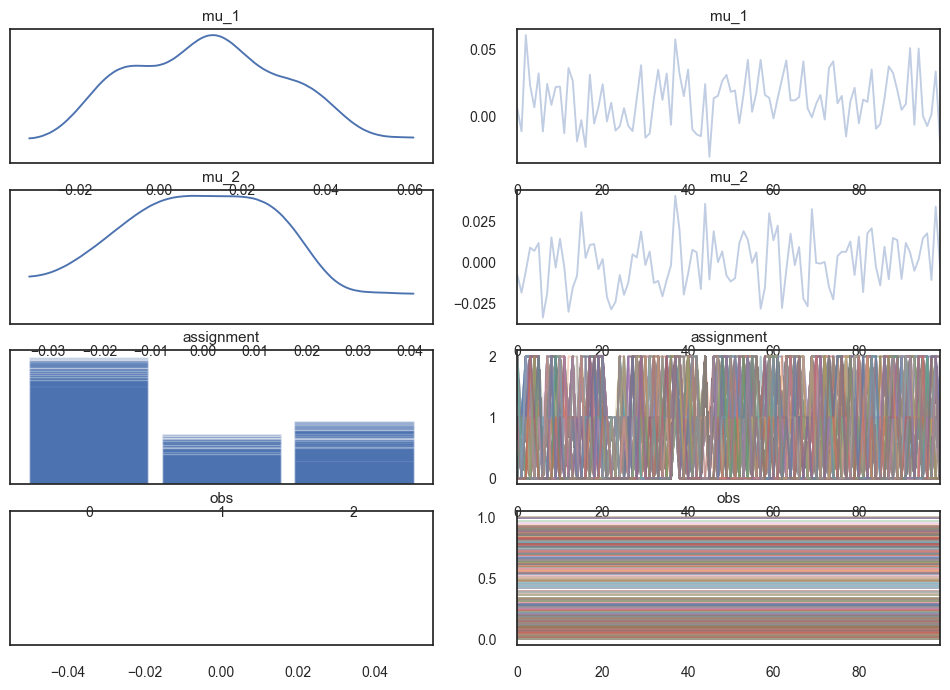

In [67]:
prior = Predictive(model_test, num_samples=100)(y_obs_label)

# Key to avoid
avoid_key = 'mu_1 > mu_2'

# Create sub-dictionary without the avoid_key
prior = dict((key, value) for key, value in prior.items() if key != avoid_key)

data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [68]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test, step_size=0.0085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10, init_strategy=init_to_mean)
#nuts_kernel = NUTS(model_test, step_size=0.00085, adapt_step_size=True, target_accept_prob=0.9, max_tree_depth=10)
#nuts_kernel = NUTS(model_test)
initial_values = {'mu_1': torch.tensor(0.01, dtype=torch.float64),'mu_2': torch.tensor(0.01, dtype=torch.float64) }
#mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False, initial_params=initial_values)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=50, disable_validation=False)
mcmc.run(y_obs_label)

Warmup:   0%|          | 0/250 [00:00, ?it/s]

Condition number: 37152.45679940161.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.3427657542.
Condition number: 52007.342

ValueError: Model specification seems incorrect - cannot find valid initial params.

In [ ]:
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_label)
data = az.from_pyro(posterior=mcmc, prior=prior, posterior_predictive=posterior_predictive)
az.plot_trace(data)
plt.show()

In [ ]:
posterior_samples

In [ ]:
loc_mean_posterior, loc_cov_posterior =[], []
for key, values in posterior_samples.items():
    print(key)
    if key == "sample_data":
        mean = values.mean(dim=0)
        cov = values.std(dim=0)
        print("mean\n",mean)
        print("cov\n", cov)
        loc_mean_posterior.append(mean.detach().numpy())
        loc_cov_posterior.append(cov.detach().numpy())
    elif key == "sigma_data":
        print("mean\n",values.mean(dim=0), "\nstd\n", values.std(dim=0))
    else:
        print("mean\n",values.mean(), "\nstd\n", values.std())

In [ ]:
loc_mean_posterior

In [ ]:
loc_cov_posterior

In [ ]:
plt.figure(figsize=(8, 6))
x = np.linspace(-0.5,1.5,8000)
  # Combine x and y grids into a (100, 100, 2) array
for i in range(3):
    # Create a multivariate normal distribution
    rv = norm(loc_mean_posterior[0][i], loc_cov_posterior[0][i])

    # Calculate PDF values for each point in the grid
    pdf_values = rv.pdf(x)

    # Plot the Gaussian distribution using contour plot
    
    plt.scatter(x, pdf_values, s=2.5, label='Gaussian_'+str(i+1))
#plt.colorbar(label='Probability Density')
plt.xlabel('hsi_spectra')
plt.ylabel('Unnormalized Probability Density')
plt.title('Gaussian Distribution')
#plt.scatter(loc_mean[i], color='red', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data.posterior

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_1'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
az.plot_density(
    data=[data.posterior, data.prior],
    shade=.9,
    var_names=['mu_2'],
    data_labels=["Posterior Predictive", "Prior Predictive"],
    colors=[default_red, default_blue],
)
plt.show()

In [ ]:
# Update the model with the new top layer's location
interpolation_input = geo_model_test.interpolation_input
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([2]), torch.tensor([2])),
    posterior_samples["mu_1"].mean()
)
interpolation_input.surface_points.sp_coords = torch.index_put(
    interpolation_input.surface_points.sp_coords,
    (torch.tensor([5]), torch.tensor([2])),
    posterior_samples["mu_2"].mean()
)

#print("interpolation_input",interpolation_input.surface_points.sp_coords)

# # Compute the geological model
geo_model_test.solutions = gempy_engine.compute_model(
    interpolation_input=interpolation_input,
    options=geo_model_test.interpolation_options,
    data_descriptor=geo_model_test.input_data_descriptor,
    geophysics_input=geo_model_test.geophysics_input,
)

gpv.plot_2d(geo_model_test, cell_number=5, legend='force')

In [ ]:
sp_coords_copy_test2 =interpolation_input.surface_points.sp_coords
sp_coords_copy_test2

In [ ]:
sp_cord= geo_model_test.transform.apply_inverse(sp_coords_copy_test2.detach().numpy())
sp_cord

In [ ]:
geo_model_post = gp.create_geomodel(
    project_name='Gempy_post_Test',
    extent=[0, 1000, -10, 10, -900, -400],
    resolution=[100,10,100],
    refinement=7,
    structural_frame= gp.data.StructuralFrame.initialize_default_structure()
    )
gp.add_surface_points(
    geo_model=geo_model_post,
    x=sp_cord[3:,0],
    y=sp_cord[3:,1],
    z=sp_cord[3:,2],
    elements_names=['surface1', 'surface1','surface1']
)
gp.add_orientations(
    geo_model=geo_model_post,
    x=[500],
    y=[0.0],
    z=[brk1],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1.0]]
)
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_test.update_transform(gp.data.GlobalAnisotropy.NONE)  
gp.compute_model(geo_model_post, engine_config=gp.data.GemPyEngineConfig())
gpv.plot_2d(geo_model_post, cell_number=[5])
    

In [ ]:
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model_post.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=sp_cord[:3,0],
        y=sp_cord[:3,1],
        z=sp_cord[:3,2],
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)
geo_model_post.structural_frame.structural_groups[0].append_element(element2)
gp.compute_model(geo_model_post)
#gpv.plot_2d(geo_model_post, cell_number=5, legend='force')
geo_model_post.structural_frame.structural_groups[0].elements[0], geo_model_post.structural_frame.structural_groups[0].elements[1] = \
geo_model_post.structural_frame.structural_groups[0].elements[1], geo_model_post.structural_frame.structural_groups[0].elements[0]
gpv.plot_2d(geo_model_post, cell_number=5, legend='force')


In [ ]:
geo_model_post.surface_points

In [ ]:
# # Creating marginal distribution plots
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 5), joyplot=False, marginal=True, likelihood=False)
# p.plot_marginal(
#     var_names=['mu_1', 'mu_2'],
#     plot_trace=False,
#     credible_interval=.70,
#     kind='kde',
#     marginal_kwargs={"bw": 1}
# )
# plt.show()

In [ ]:
# # Visualizing the posterior distributions
# p = PlotPosterior(data)
# p.create_figure(figsize=(9, 6), joyplot=True)
# iteration = 99
# p.plot_posterior(
#     prior_var=['mu_1', 'mu_2'],
#     like_var=['mu_1', 'mu_2'],
#     obs='obs',
#     iteration=iteration,
#     marginal_kwargs={
#         "credible_interval": 0.94,
#         'marginal_kwargs': {"bw": 1},
#         'joint_kwargs': {"bw": 1}
#     }
# )
# plt.show()

In [ ]:
# # Creating a pair plot for selected parameters
# az.plot_pair(data, divergences=False, var_names=['mu_1', 'mu_2'])
# plt.show()